# Loading imagenet-1k dataset

# Importing libraries

In [13]:
import os
import numpy as np
import math
import random

import matplotlib.pyplot as plt
#import matplotlib.cm as cm

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
import torchvision

from PIL import Image

import itertools

# imagenet-1k

In [14]:
from datasets import list_datasets
import os

datasets_list = list_datasets()
len(datasets_list)

36658

In [2]:
for ds in datasets_list:
    if "imagenet-1k" in ds.lower():
        print(ds)

imagenet-1k
ChristophSchuhmann/Imagenet-1k-SD-1.4
theodor1289/imagenet-1k_tiny
AlexFierro9/imagenet-1k_test


In [5]:
#in order to download imagenet-1k, we must logging first.
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset
dataset = load_dataset(path = "imagenet-1k",
                       cache_dir = ".." + os.sep + ".." + os.sep + "Dataset_Collection", 
                       download_mode = "reuse_dataset_if_exists")

Found cached dataset imagenet-1k (/Users/roisinjiaolinluo/Documents/Research/AI_Research/imagenet1k_download/../../Dataset_Collection/imagenet-1k/default/1.0.0/a1e9bfc56c3a7350165007d1176b15e9128fcaf9ab972147840529aed3ae52bc)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
})

In [10]:
dataset.set_format(type='torch', columns=['image', 'label'])

In [11]:
dataset_train_ = dataset['train']
dataset_val_ = dataset['validation']
dataset_test_ = dataset['test']

In [85]:
class ImageNet1kDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 dataset, 
                 transforms = None,
                 random_seed = 42):
        
        self.dataset = dataset
        self.dataset_size = len(dataset)
        
        #transforms_ = []
        #
        #if image_size is not None:
        #    transforms_.append(torchvision.transforms.Resize(image_size))
        #
        #
        #self.transforms = torchvision.transforms.Compose(transforms_)
        
        self.transforms = transforms
        
        np.random.seed(random_seed)
        
    def __getitem__(self, index):
        image = self.dataset[index]['image']
        label = self.dataset[index]['label']
        
        image = image.float()
        image = image.permute(2,1,0)
        image = image / 255.0
    
        image = torch.transpose(image, 1, 2)
    
        if self.transforms is not None:
            image = self.transforms(image) 
        return image, label
    
    def __len__(self):
        return self.dataset_size

In [86]:
ds_mean = np.array([0.485, 0.456, 0.406])
ds_std = np.array([0.229, 0.224, 0.225])
    
transforms = torchvision.transforms.Compose([
                    #torchvision.transforms.ToTensor(),
                    torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.Normalize(ds_mean, ds_std)
                    ])
    
dataset_train = ImageNet1kDataset(dataset_train_, transforms = transforms)
dataset_val = ImageNet1kDataset(dataset_val_, transforms = transforms)
dataset_test = ImageNet1kDataset(dataset_test_, transforms = transforms)

In [87]:
image, label = dataset_train[0]

In [88]:
image.shape

torch.Size([3, 224, 224])

In [89]:
label

tensor(726)

In [90]:
def deznormalize_images_bcwh(x, 
                       ds_mean = np.array([0.485, 0.456, 0.406]),
                       ds_std = np.array([0.229, 0.224, 0.225])):
    
    x = torch.permute(x, (0, 2, 3, 1))  
    x = x * ds_std + ds_mean
    x = torch.permute(x, (0, 3, 1, 2)) 
    return x

In [91]:
image = image.unsqueeze(0)
image = deznormalize_images_bcwh(image)
image = image.squeeze(0)

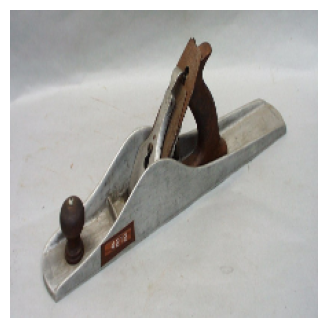

In [92]:
plt.figure(figsize=(4,4))
plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
plt.axis('off')
plt.show()

In [93]:
batch_size=8

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [94]:
x,y = next(iter(dataloader_train))

In [95]:
x.shape

torch.Size([8, 3, 224, 224])

In [96]:
y

tensor([767, 873, 962, 126, 356, 568, 178, 430])

In [97]:
def deznormalize_images(x, 
                       ds_mean = np.array([0.485, 0.456, 0.406]),
                       ds_std = np.array([0.229, 0.224, 0.225])):
    
    assert x.shape[-1] == 3, "needs channel last format."
    
    return x * ds_std + ds_mean

In [98]:
def visualize_images(x,  # B x C x H x W
                     nrows, 
                     ncols, 
                     replace_sampling = True, 
                     deznormalize = True,
                     pseudo_color = False,
                     subfig_width = 6.5, 
                     subfig_height = 6.5):
    
    indices = list(range(len(x)))
        
    if nrows * ncols > len(indices):
        indices_ = np.random.choice(indices, nrows * ncols, replace = replace_sampling)
    else:
        indices_ = indices
    
    x_ = x[indices_]
    
    print("x_.shape = ", x_.shape)
    
    if deznormalize:
        x_ = torch.permute(x_, (0, 2, 3, 1))
        x_ = deznormalize_images(x_)
        x_ = torch.permute(x_, (0, 3, 1, 2))
        
    print("x_.shape = ", x_.shape)
    
    if pseudo_color:
        x_ = apply_pseudocolor_batch(x_)
    
    #create grid with size by nrows x ncols
    img_grid = make_grid(tensor = x_, 
                         nrow = ncols, 
                         padding = 10, 
                         pad_value = 1)

    print("img_grid.shape = ", img_grid.shape)
   

    #img_grid = (img_grid + 1) / 2
    print(torch.min(img_grid))
    print(torch.max(img_grid))

    fig_width = subfig_width * nrows
    fig_height = subfig_height * ncols

    img_grid = img_grid.permute(1, 2, 0)
    img_grid = img_grid.clip(0, 1)
    
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()

x_.shape =  torch.Size([8, 3, 224, 224])
x_.shape =  torch.Size([8, 3, 224, 224])
img_grid.shape =  torch.Size([3, 478, 946])
tensor(-4.0531e-09, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64)


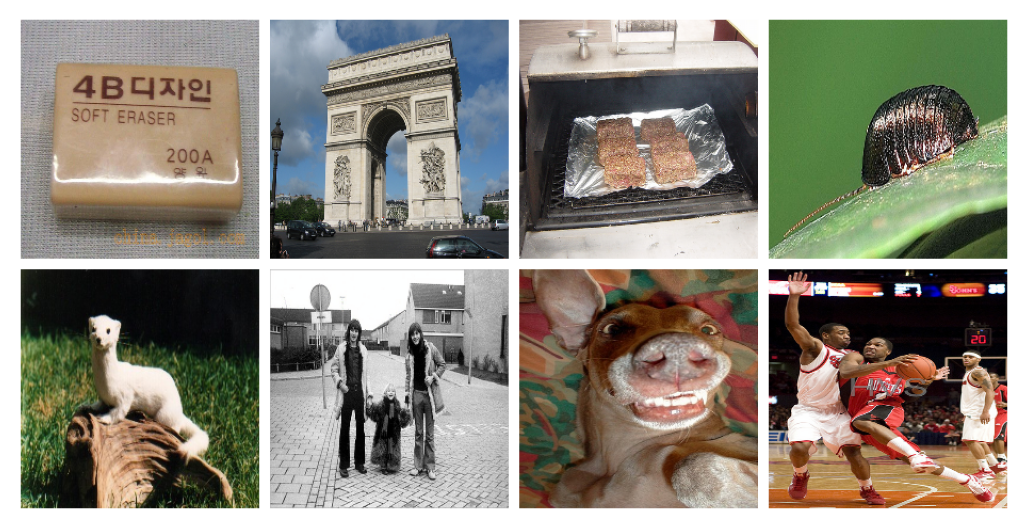

In [99]:
visualize_images(x = x, nrows = 2, ncols = 4, deznormalize = True)